<a href="https://colab.research.google.com/github/Barikko/Yandex.Practicum-Projects/blob/main/%D0%9D%D0%B5%D0%B4%D0%B2%D0%B8%D0%B6%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

# Общая информация. 

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

None

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


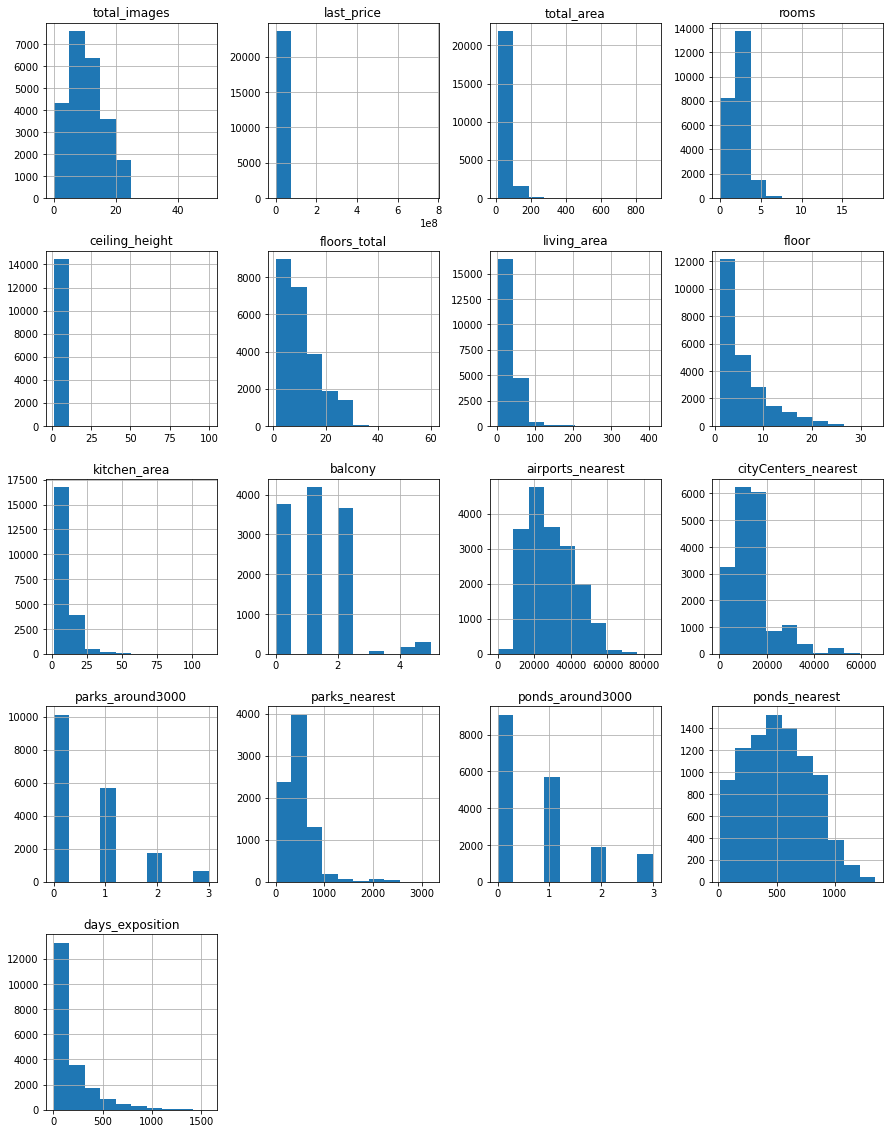

In [363]:
data = pd.read_csv('/content/sample_data/real_estate_data.csv', sep='\t')
display(data.columns)
display(data.info())
display(data.head(5))
#Посмотрели основную информацию
data.hist(figsize=(15, 20));

В датафрейме 22 колонки, тип большей части из них - вещественное число, сразу можно увидеть, что в таблице много пропусков,  особенно в колонке is_apartment.

# Предобработка данных

In [364]:
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


ceiling_height, living_area, kitchen_area  - заменю пропуски на медиану
floors_total, parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, days_exposition, locality_name, airports_nearest, cityCenters_nearest - оставлю пропуски
is_apartment - заменю на Фолс, если нет ответа, то это не апартаменты 
balcony - заменю на 0, нет ответа - нет балкона

In [365]:
#Избавляюсь от пропусков
data['ceiling_height']=data['ceiling_height'].fillna(data['ceiling_height'].median())
koef = data['total_area'].mean()/data['living_area'].mean()
data['living_area'] = data['living_area'].fillna(data['total_area']/koef)
koef2 = (data['total_area'].mean()-data['living_area'].mean())/data['kitchen_area'].mean()
data['kitchen_area'] = data['kitchen_area'].fillna((data['total_area']-data['living_area'])/koef2)
data[['kitchen_area', 'living_area','total_area']][(data['kitchen_area'] + data['living_area']) > data['total_area']]

,kitchen_area,living_area,total_area
184,6.20,26.10,30.20
545,5.00,20.00,23.80
551,9.28,30.55,31.59
601,7.00,48.30,53.70
696,23.43,23.43,34.69
...,...,...,...
21824,8.60,38.00,44.00
21868,8.00,30.60,34.30
21915,32.40,62.00,91.40
21956,8.00,44.00,46.00


In [366]:
#Меняю пропущенные значения в balcony на 0, а в is_apartment - на False
data['balcony']=data['balcony'].fillna(0)
data['floors_total']=data['floors_total'].fillna(0)
data['is_apartment']=data['is_apartment'].fillna(False)

In [367]:
print(data.isna().sum())
#Оставили пропуски там, где нет логичной замены

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Откуда могли взяться пропуски?
Большое количество пропусков в столбцах, где их отсутствие не помешало нам при обработке данных (is apartment, balcony), так что и заполнять эти данные было не необходимо, если квартира действительно не апартаменты и действительно не имеет балкона, как мы и указали вместо пропусков
Также в объявлении 22 пункта для заполнения, необходимо указать большое количество информации, что может быть непростой задачей для того, кто размещает объявление.

In [368]:
#Тип данных надо поменять в столбце first_day_exposition, так как это дата
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['last_price'] = data['last_price'].astype(int)
data['floors_total'] = data['floors_total'].astype('Int64')
data['balcony'] = data['balcony'].astype('Int64')
data['parks_around3000'] = data['parks_around3000'].astype('Int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('Int64')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  Int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

In [369]:
#Убираем неявные дубликаты. Приведём все названия к общему виду
data['locality_name'] = data['locality_name'].replace('поселок','посёлок', regex=True)
data['locality_name'] = data['locality_name'].replace('деревня','городской посёлок', regex=True)
data['locality_name'] = data['locality_name'].replace('село','городской посёлок', regex=True)
data['locality_name'] = data['locality_name'].replace('поселок при железнодорожной станции','поселок станции', regex=True)
data['locality_name'] = data['locality_name'].replace('садоводческое некоммерческое товарищество','садовое товарищество', regex=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  Int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

In [370]:
#Находим аномальные значения
x=data.shape[0]
data.loc[data.ceiling_height > 20, "ceiling_height"] = data.ceiling_height/10
data = data.loc[data['floors_total']<50]
data = data.loc[(data['rooms']>0) & (data['rooms']<20)]
cols = ['total_area','living_area','kitchen_area']
data=data[~data[cols].isna().any(1)&(data['total_area']*0.6 <=data['living_area']+data['kitchen_area'])]
y=data.shape[0]
print('Удалено {:.1f}% значений'.format(abs(100 - x * 100 / y))) 

Удалено 2.5% значений


Встречается много аномальных значений по типу очень маленький или наоборот очень больших площадей, общих этажей, комнат.

# Новые столбцы

In [371]:
#Цена одного метра
data['meter_price'] = data['last_price']/data['total_area']

In [372]:
#День недели публикации объявления

def day(data):
    if data.dayofweek == 0:
        return 'Понедельник'
    if data.dayofweek == 1:
        return 'Вторник'
    if data.dayofweek == 2:
        return 'Среда'
    if data.dayofweek == 3:
        return 'Четверг'
    if data.dayofweek == 4:
        return 'Пятница'
    if data.dayofweek == 5:
        return 'Суббота'
    if data.dayofweek == 6:
        return 'Воскресенье' 
data['day'] = data['first_day_exposition'].apply(day)


In [373]:
#Месяц публикации объявления 
data['month'] = data['first_day_exposition'].dt.month_name()

In [374]:
#Год публикации объявления
data['year'] = data['first_day_exposition'].dt.year

In [375]:
#Тип этажа квартиры
def floor(data):
    if data.floor == data.floors_total:
        return 'Последний'
    elif data.floor == 1:
        return 'Первый'
    else:
        return 'Другой'
data['floor_type'] = data.apply(floor, axis=1)

In [376]:
#Расстояние в км до центра города
data['km'] = data['cityCenters_nearest']/1000

# Исследовательский анализ данных

## Гистограммы

Медиана площади квартиры: 52.0


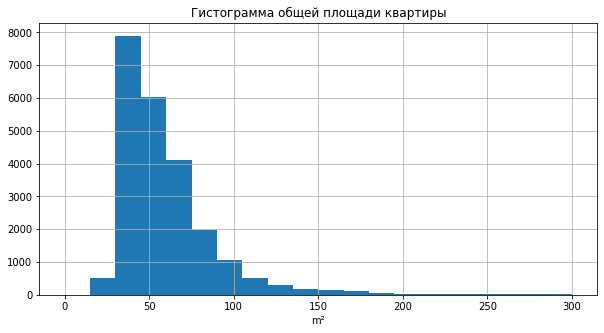

In [377]:
#Общая площадь
data['total_area'].hist(bins = 20, range=(0,300),figsize=(10, 5)).set_title('Гистограмма общей площади квартиры')
plt.xlabel('m²')
print('Медиана площади квартиры:',data['total_area'].median())

В среднем основная площадь квартир равняется от менее 50 до 100+ метров.
Встречаются и огромные квариры с площадями в 200 и более метров, они в ходят в более дорогой сегмент, поэтому их гораздо меньше

Медиана жилой площади: 30.0


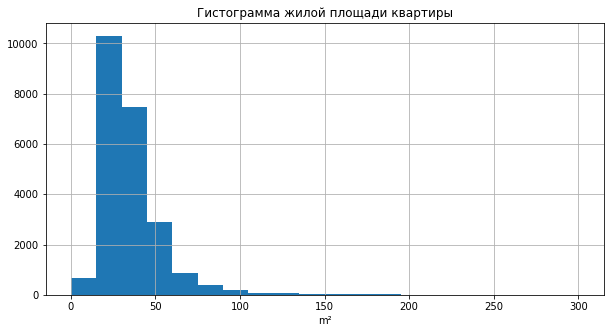

In [378]:
#Жилая площадь
data['living_area'].hist(bins = 20, range=(0,300),figsize=(10, 5)).set_title('Гистограмма жилой площади квартиры')
plt.xlabel('m²')
print('Медиана жилой площади:',data['living_area'].median())

Средний метраж жилой площади - от 20 до 60, жилих площадей с более чем 100м очень мало, они также принадлежат к дорогому сегменту

Медиана площади кухни: 9.0


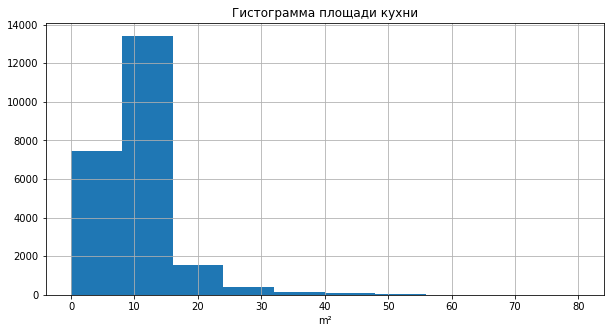

In [379]:
#Площадь кухни
data['kitchen_area'].hist(bins = 10, range=(0,80),figsize=(10, 5)).set_title('Гистограмма площади кухни')
plt.xlabel('m²')
print('Медиана площади кухни:',data['kitchen_area'].median())

В среднем площадь кухни занимает до 20м с редким увеличеним вплоть до 60м

Медиана цены объекта: 4650000.0


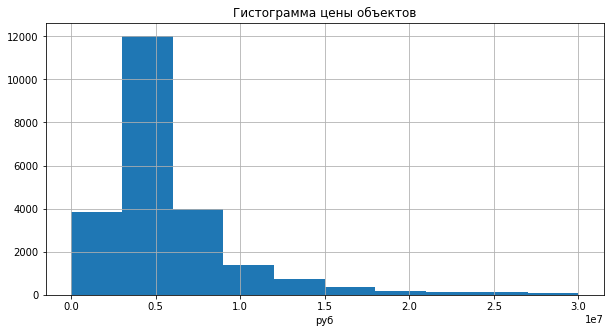

In [380]:
#Цена объекта
data['last_price'].hist(bins = 10, range=(0,30000000),figsize=(10, 5)).set_title('Гистограмма цены объектов')
plt.xlabel('руб')
print('Медиана цены объекта:',data['last_price'].median())

Медиана цены, за которую были проданы объекты - 4.65млн.

Медиана количества комнат: 2.0


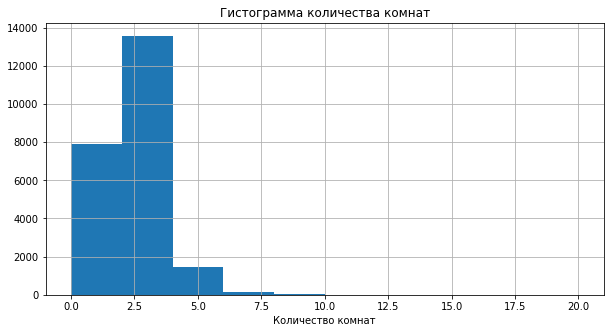

In [381]:
#Количество комнат
data['rooms'].hist(bins = 10, range=(0,20),figsize=(10, 5)).set_title('Гистограмма количества комнат')
plt.xlabel('Количество комнат')
print('Медиана количества комнат:',data['rooms'].median())

Среднее количество комнат - 2, но встречаются и большие многокомнатные дома с 5 и более комнатами

Медиана высоты потолков: 2.65


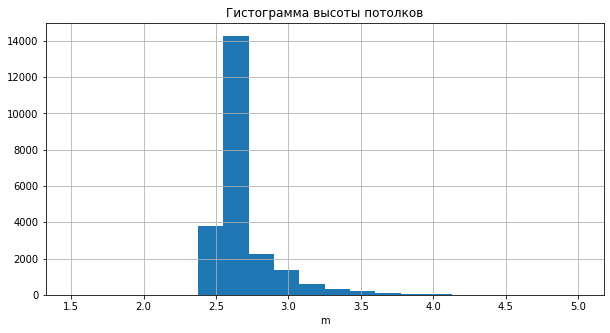

In [382]:
#Высота потолков
data['ceiling_height'].hist(bins = 20, range=(1.5,5),figsize=(10, 5)).set_title('Гистограмма высоты потолков')
plt.xlabel('m')
print('Медиана высоты потолков:',data['ceiling_height'].median())

Высота потолков - 2.65м, с увеличенем высоты потолков уменьшается количество квартир.

Медиана: 4.0


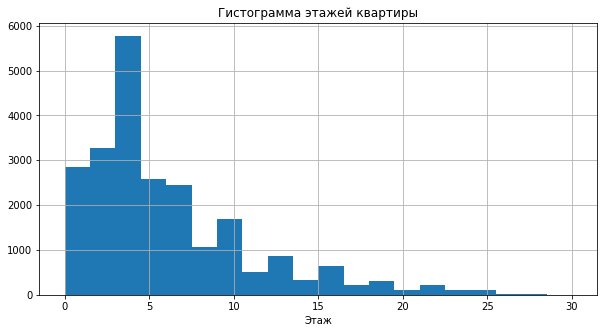

In [383]:
#Этаж квартиры
data['floor'].hist(bins = 20, range=(0,30),figsize=(10, 5)).set_title('Гистограмма этажей квартиры')
plt.xlabel('Этаж')
print('Медиана:',data['floor'].median())

Большинство квартир расположены от 1 до 10 этажа, некоторые объекты располагаются в многоэтажных постройках с 15 и более этажами.

In [384]:
#Тип этажа квартиры («первый», «последний», «другой»)
print(data.groupby('floor_type')['floor_type'].count())


floor_type
Другой       17026
Первый        2822
Последний     3271
Name: floor_type, dtype: int64


Первый этаж наименее популярен по сравнению с последним и остальными.

Медиана количества этажей: 9.0


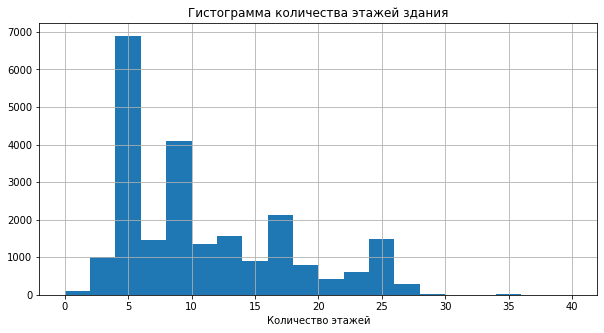

In [385]:
#Общее количество этажей в доме
data['floors_total'].hist(bins = 20, range=(0,40),figsize=(10, 5)).set_title('Гистограмма количества этажей здания')
plt.xlabel('Количество этажей')
print('Медиана количества этажей:',data['floors_total'].median())

Большее количество квартир располагаются в пяти- и десятиэтажках, далее количество многоэтажных зданий уменьшается.

Медиана расстояния до центра города в метрах: 13107.0


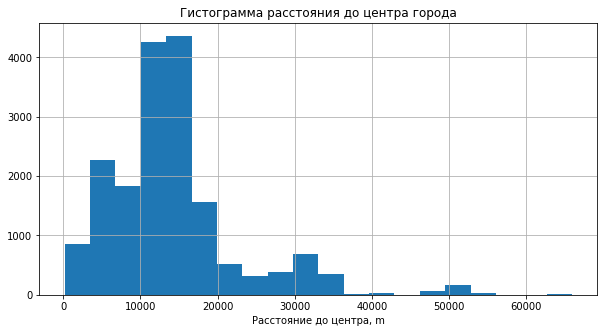

In [386]:
#Расстояние до центра города в метрах
data['cityCenters_nearest'].hist(bins = 20,figsize=(10, 5)).set_title('Гистограмма расстояния до центра города')
plt.xlabel('Расстояние до центра, m')
print('Медиана расстояния до центра города в метрах:',data['cityCenters_nearest'].median())

Большинство квартир находятся на расстоянии более 10км от центра, чем ближе к центру квартира, тем она дороже.

Медиана расстояния до ближайшего аэропорта: 26729.0


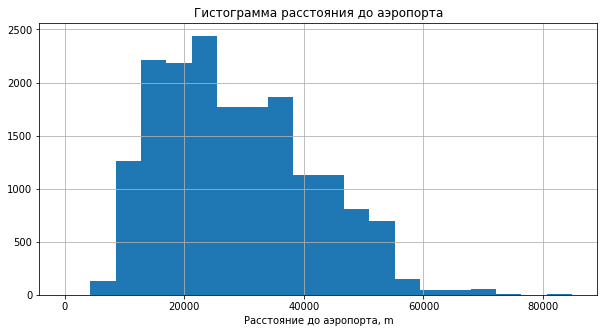

In [387]:
#Расстояние до ближайшего аэропорта
data['airports_nearest'].hist(bins = 20,figsize=(10, 5)).set_title('Гистограмма расстояния до аэропорта')
plt.xlabel('Расстояние до аэропорта, m')
print('Медиана расстояния до ближайшего аэропорта:',data['airports_nearest'].median())

Рядом с аэропортом практически нет квартир, все они удалены на расстояние от 10 до 60км от него.

Медиана расстояния до ближайшего парка: 453.0


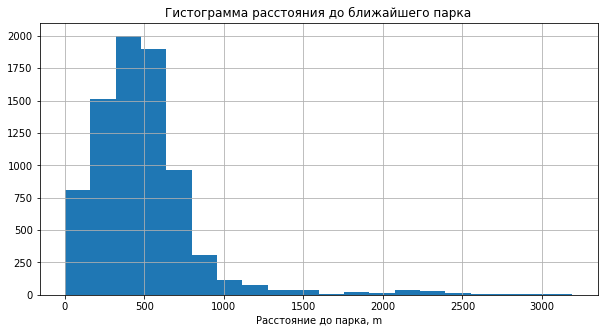

In [388]:
#Расстояние до ближайшего парка
data['parks_nearest'].hist(bins = 20,figsize=(10, 5)).set_title('Гистограмма расстояния до ближайшего парка')
plt.xlabel('Расстояние до парка, m')
print('Медиана расстояния до ближайшего парка:',data['parks_nearest'].median())

Рядом почти со всеми предложениями находится парк, до 1км, но встречаются и варианты, где расстояние до парка составляет два и более километра.

In [389]:
#День и месяц публикации объявления;
display(data.groupby('day')['floor_type'].count().sort_values())
print('------')
display(data.groupby('month')['floor_type'].count().sort_values())

day
Воскресенье    1670
Суббота        1886
Понедельник    3528
Среда          3883
Пятница        3890
Вторник        4082
Четверг        4180
Name: floor_type, dtype: int64

------


month
May          1250
January      1467
December     1596
July         1651
August       1693
June         1731
September    1912
October      2062
November     2304
April        2335
March        2535
February     2583
Name: floor_type, dtype: int64

Наибольшее количество объявлений запощено во вторник, пятницу и четверг, 
воскресенье и суббота - самые неактивные дни для объявлений
Апрель, Февраль, Март и Ноябрь - самые частые месяцы для объявлений

## Скаттеры

Корреляция: 0.64


/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


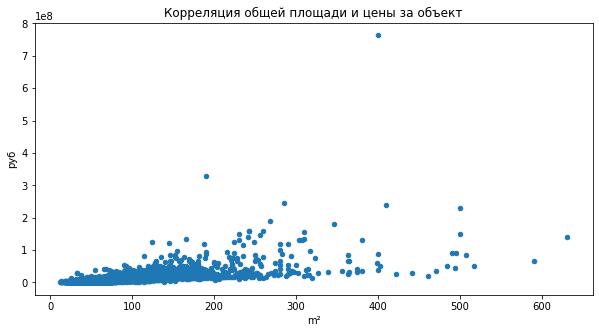

In [390]:
#Влияет ли общая площадь на цену
print('Корреляция: %.2f'%data['last_price'].corr(data['total_area']))
data.plot(x='total_area', y='last_price', kind = 'scatter',ylabel='руб',\
          figsize=(10,5),title='Корреляция общей площади и цены за объект',xlabel='m²');

Общая площадь является самым влияющим фактором, с увеличением площади увеличивается и цена квартиры

Корреляция: 0.58


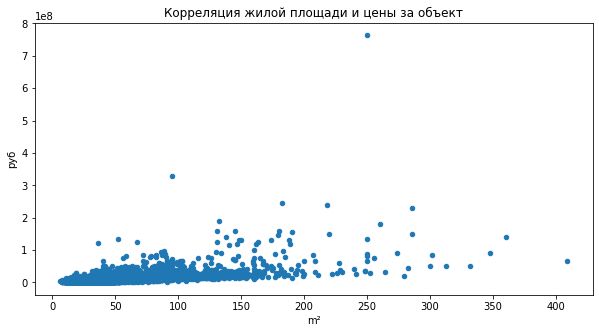

In [391]:
#Влияет ли жилая площадь
print('Корреляция: %.2f'%data['last_price'].corr(data['living_area']))
data.plot(x='living_area', y='last_price', kind = 'scatter',ylabel='руб',\
          figsize=(10,5),title='Корреляция жилой площади и цены за объект',xlabel='m²');

Жилая площадь тоже влияет на цену, но в меньшей степени

Корреляция: 0.51


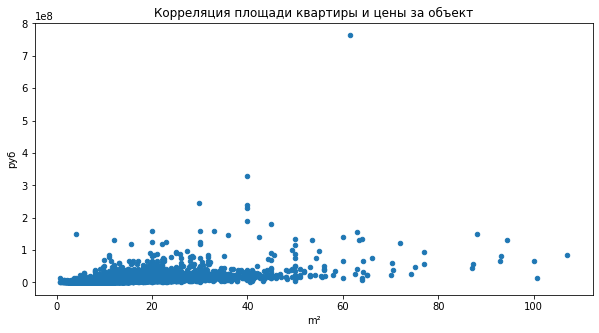

In [392]:
#Влияет ли площадь кухни
print('Корреляция: %.2f'%data['last_price'].corr(data['kitchen_area']))
data.plot(x='kitchen_area', y='last_price', kind = 'scatter',ylabel='руб',\
          figsize=(10,5),title='Корреляция площади квартиры и цены за объект',xlabel='m²');

Площадь кухни влияет меньше остальных площадей квартиры

## Продолжение анализа

Корреляция: 0.37


,last_price
rooms,
1,3.810713e+06
2,5.516448e+06
3,8.077167e+06
4,1.312412e+07
5,2.215357e+07
6,3.155172e+07
7,4.498479e+07
8,4.977900e+07
9,3.189286e+07


Axes(0.125,0.125;0.775x0.755)


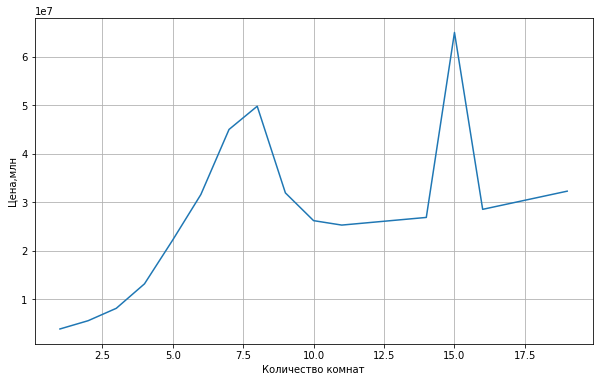

In [393]:
#Влияние количества комнат на цену
print('Корреляция: %.2f'%data['last_price'].corr(data['rooms']))
display(data
    .pivot_table(index = 'rooms',values='last_price'))
print(data
    .pivot_table(index = 'rooms',values='last_price')
    .plot(grid=True, figsize=(10,6),title='',xlabel='Количество комнат',ylabel='Цена,млн',legend=False));

С увеличением комнат увеличивается и цена квартиры

In [394]:
#Влияние этажа на цену
display(data.pivot_table(index = 'floor_type',values='last_price'))
print('Средняя цена квартиры на последнем этаже: %.0f'%data.query('floor_type == "Последний"')['last_price'].mean())
print('Средняя цена квартиры на первом этаже: %.0f'%data.query('floor_type == "Первый"')['last_price'].mean())
print('Средняя цена квартиры на другом этаже: %.0f'%data.query('floor_type == "Другой"')['last_price'].mean())

,last_price
floor_type,
Другой,6.616438e+06
Первый,4.749129e+06
Последний,6.737604e+06


Средняя цена квартиры на последнем этаже: 6737604
Средняя цена квартиры на первом этаже: 4749129
Средняя цена квартиры на другом этаже: 6616438


Квартиры ценятся больше всего не на первом или последнем этажах, менее всего - на первом.

,last_price
day,
Воскресенье,6.131821e+06
Вторник,6.256233e+06
Понедельник,6.376186e+06
Пятница,6.341999e+06
Среда,6.440708e+06
Суббота,6.683341e+06
Четверг,6.587204e+06


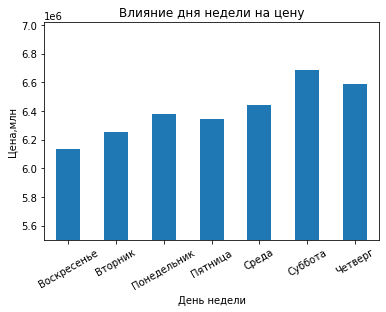

In [395]:
#Влияние дня недели на цену
x=data.pivot_table(index = 'day',values='last_price')
display(x)
x.plot(kind='bar',title='Влияние дня недели на цену',xlabel='День недели',ylabel='Цена,млн',ylim=5500000,legend=False)
plt.xticks(rotation = 30);

,last_price
month,
April,6.639205e+06
August,6.319367e+06
December,6.492935e+06
February,6.296402e+06
January,6.639886e+06
July,6.601193e+06
June,6.134091e+06
March,6.199553e+06
May,6.607800e+06


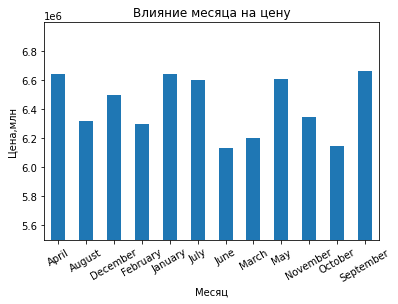

In [396]:
#Влияние месяца на цену
x=data.pivot_table(index = 'month',values='last_price')
display(x)
x.plot(kind='bar',title='Влияние месяца на цену',xlabel='Месяц',ylabel='Цена,млн',ylim=5500000,legend=False)
plt.xticks(rotation = 30);

,last_price
year,
2014,1.198467e+07
2015,8.298337e+06
2016,6.597272e+06
2017,6.421356e+06
2018,5.901575e+06
2019,6.615701e+06


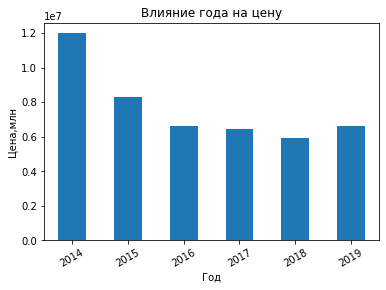

In [397]:
#Влияние года на цену
x=data.pivot_table(index = 'year',values='last_price')
display(x)
x.plot(kind='bar',title='Влияние года на цену',xlabel='Год',ylabel='Цена,млн',legend=False)
plt.xticks(rotation = 30);

От дня недели и месяца цена квартиры практически не зависит.

Самыми важными факторам, формирующими цену, оказалась площадь квартиры и её этаж, чем больше площадь и чем выше этаж(кроме последнего), тем дороже объект, день недели и время года, в свою очередь, не влияют на цену.

In [398]:
#Средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.
array = data.groupby('locality_name')['meter_price'].count().sort_values(ascending=False).head(10)
data[data['locality_name'].isin(array.index)]\
                                        .groupby('locality_name')['meter_price']\
                                        .mean().sort_values(ascending=False)

locality_name
Санкт-Петербург              114346.560973
Пушкин                       103242.808899
городской посёлок Кудрово     92381.749297
посёлок Парголово             90551.014769
посёлок Мурино                85037.358534
посёлок Шушары                78438.202943
Колпино                       75398.579332
Гатчина                       69085.459818
Всеволожск                    68736.519972
Выборг                        58355.641964
Name: meter_price, dtype: float64

Самая дорогая цена за метр - Санкт-Петербург, Пушкин, самая дешёвая - Выборг, Всеволожск

Медиана дней: 96.0
Среднее дней: 181.51394581625513
Среднее среди квартир с фотографиями 5 и менее: 204.20801393728223


,days_exposition
total_images,
1,205.832474
2,210.423009
3,198.890882
4,202.795349
5,192.911504
6,197.888031
7,184.279789
8,181.504047
9,172.621202


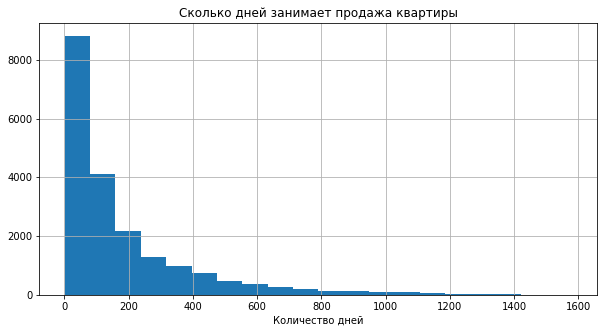

In [399]:
#Сколько дней занимает продажа квартиры
print('Медиана дней:',data['days_exposition'].median())
print('Среднее дней:',data['days_exposition'].mean())
print('Среднее среди квартир с фотографиями 5 и менее:'
      ,data.loc[(data['total_images']>0)&(data['total_images']<5)]['days_exposition'].mean())
data_short=data.query('total_images>0 & total_images<11')
display(data_short.pivot_table(index = 'total_images',values='days_exposition'))
data['days_exposition'].describe()
data['days_exposition'].hist(bins = 20,figsize=(10, 5)).set_title('Сколько дней занимает продажа квартиры')
plt.xlabel('Количество дней');

В среднем продажа занимает 180 дней или полгода, медиана - 95 дней. Продажу можно считать быстрой, если она заняла менее 45 дней. Долгая продажа - продажа, занявшая более 230 дней. Встречаются и долгие продажи с 1000, 1400 дней ожидания, или несколько лет.
Стоит обратить внимание на количество фотографий в объявлении, они тоже влияют на скорость продажи, 
чем меньше фотографий, тем дольше идёт продажа, 
объявления с менее чем 5 фотографиями продаются в среднем на 20 дней дольше

,last_price
km,
1.0,3.306545e+07
2.0,1.986841e+07
3.0,1.619439e+07
4.0,1.114165e+07
5.0,1.334237e+07
6.0,1.384185e+07
7.0,1.491534e+07
8.0,1.446702e+07
9.0,9.047302e+06


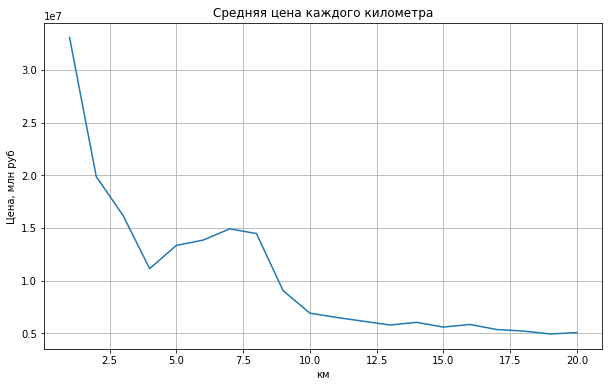

In [400]:
#Средняя цена каждого километра
spb = data.query('locality_name == "Санкт-Петербург"')
x=spb.pivot_table(index = round(spb['km'])+1,values='last_price').head(20)
display(x)
x.plot(grid=True, figsize=(10,6),title='Средняя цена каждого километра',xlabel='км',ylabel='Цена, млн руб',legend=False);

Чем ближе объект к центру, тем выше его цена, за 20 километров цена за объект упала более чем в три раза, с 25млн до 7 млн

# Общий вывод

Большее количество квартир на продажу имеют 2 комнаты и общую площадь от 50м2 до 100м2, находятся на далёком расстоянии от центра (более 10км) и имеют среднюю цену в 4,65млн. Рядом почти со всеми объектами рядом (менее 1км) находится парк. Большая часть домов расположена в пяти- или десятиэтажках. Встречаются и выбросы в виде многокомнатных домов или домов с огромной площадью. Санк-Петребург - самый популярный и дорогой район продаж, квартира в центре будет стоит около 25млн рублей, близость к центру очень сильно влияет на цену объекта, за 20км от центра цена падает более чем в три раза до 7млн. Главный ценообразующий параметр - общая площадь квартиры, у этого параметра самая сильная корреляция с ценой продажи, также для покупателей важен этаж квартиры, первый и последние ценятся меньше остальных. С увеличением комнат, общей площади, удалённости от центра увеличивается и цена квартиры.

Такие параметры, как день недели и месяц, не влияют на цену объекта, обычно покупатель находится в течение полугода, но один из факторов, влияющих на это - количество фотографий, если их менее 5, объявление висит дольше на несколько недель.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [X]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного метра
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [X]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [X]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод